In [1]:
import sys
import tqdm
import time
import sklearn
import numpy as np
import pandas as pd
import scipy
import copy
import random
import math
import torch
import torch.nn.functional as F
# from load_dataset import load
# from classifier import NeuralNetwork, LogisticRegression, SVM
# from utils import *
# from metrics import *  # include fairness and corresponding derivatives
from scipy import stats
from scipy.stats import rankdata
from sklearn import metrics, preprocessing
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report
from sklearn.svm import SVC, LinearSVC
from torch.autograd import grad
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Markdown, display
random.seed(1)
np.random.seed(1)
# torch.manual_seed(1)

**Deviations**

In [43]:
'''SVM'''
deviation_spd = ([0.008650498781617917, 0.0016810144299143938, 0.006298400055212338],
 [0.003916554083600427, 0.0013346615947148423, 0.0008366749052780956],
 [7.433310935371567e-05, 0.0007275228181646862, 0.0001429245940276967])
deviation_tpr_parity = ([0.008373272002829855, 0.0016139904229192793, 0.007433042527481547],
 [0.003970293677494806, 0.0016276071934501748, 0.006311986734084454],
 [0.00029551068835424895, 0.0008417491963423673, 0.000544626240131496])
deviation_predictive_parity = ([0.014909765514185542, 0.0010677627279692293, 0.008945317058605719],
 [0.007602717556633709, 0.0007403490299594361, 0.004231786441651254],
 [0.0015077806806889527, 0.00026425485548731647, 0.0005036813238717963])

In [46]:
deviation_spd = ([0.10869965203308352, 0.00562099571438867, 0.03860063945947978],
 [0.022405363829455904, 0.006753801694182531, 0.0340642396070962],
 [0.10509994721505789, 0.0104527373275166, 0.017468513618223436])
deviation_tpr_parity = ([0.08216970908777388, 0.005436790686102928, 0.020021863443473342],
 [0.010695333034476506, 0.003915415501546139, 0.010249575433491122],
 [0.07552686653211027, 0.010173515623152172, 0.03087607727582581])
deviation_predictive_parity = ([0.0249518052235922, 0.0023275617822628887, 0.043483832079328405],
 [0.02178738414383235, 0.00202037542827583, 0.02956565091936496],
 [0.019704999034755755, 0.0031082469406355827, 0.04089885337473542])

In [47]:
deviation_first = []
deviation_first += deviation_spd[0]
deviation_first +=  [0]
deviation_first += deviation_tpr_parity[0]
deviation_first +=  [0]
deviation_first += deviation_predictive_parity[0]

deviation_second = []
deviation_second += deviation_spd[1]
deviation_second +=  [0]
deviation_second += deviation_tpr_parity[1]
deviation_second +=  [0]
deviation_second += deviation_predictive_parity[1]

deviation_gd = []
deviation_gd += deviation_spd[2]
deviation_gd +=  [0]
deviation_gd += deviation_tpr_parity[2]
deviation_gd +=  [0]
deviation_gd += deviation_predictive_parity[2]

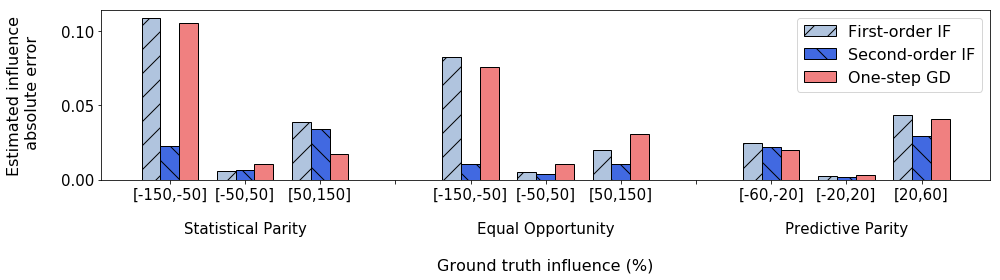

In [53]:
plt.figure(figsize=(14,4))
width = 0.25
alpha = 0.6
bin_num = 3

edge_color = np.zeros((bin_num, 4))
edge_color[:, 3] = 1.0 # alpha
edge_width = 1

bar_color_first = np.zeros((bin_num, 4))
bar_color_first[:, 2] = 1.0 # blue
bar_color_first[:, 3] = 0.2 # alpha

bar_color_second = np.zeros((bin_num, 4))
bar_color_second[:, 2] = 1.0 # blue
bar_color_second[:, 3] = 0.7 # alpha

bar_color_gd = np.zeros((bin_num, 4))
bar_color_gd[:, :1] = 1.0 # :3 yellow
bar_color_gd[:, 3] = 0.5 # alpha

index = np.arange(bin_num*3+2)
plt.bar(index-width, deviation_first, width, label='First-order IF', color='lightsteelblue',\
        linewidth=edge_width, edgecolor=edge_color, hatch='/')
plt.bar(index, deviation_second, width, label='Second-order IF', color='royalblue',\
       linewidth=edge_width, edgecolor=edge_color, hatch='\\')
plt.bar(index+width, deviation_gd, width, label='One-step GD', color='lightcoral',\
       linewidth=edge_width, edgecolor=edge_color)
ticks_1 = [f'[{(2*bin_id-3)*50},{(2*bin_id-1)*50}]' for bin_id in range(bin_num)]
ticks_1[1] += '\n\nStatistical Parity'
ticks_2 = [f'[{(2*bin_id-3)*50},{(2*bin_id-1)*50}]' for bin_id in range(bin_num)]
ticks_2[1] += '\n\nEqual Opportunity'
ticks_3 = [f'[{(2*bin_id-3)*20},{(2*bin_id-1)*20}]' for bin_id in range(bin_num)]
ticks_3[1] += '\n\nPredictive Parity'
# print(ticks_1)
# print(ticks_2)
# print(ticks_3)
plt.xticks(range(bin_num*3+2), ticks_1 + [''] + ticks_2 + [''] + ticks_3, rotation=0, fontsize=15)
plt.yticks(np.arange(0, 0.15, .05), fontsize=15)
# plt.grid()
plt.ylabel('Estimated influence\n absolute error\n', fontsize=16)
# , fontweight='bold')
plt.xlabel('\nGround truth influence (%)',\
           fontsize=16)
#            , fontweight='bold')
# plt.legend(fontsize=12, prop={'weight':'bold'})
plt.legend(fontsize=16)
plt.tight_layout()
# plt.show()
plt.savefig('effectiveness.pdf', dpi=150)

**Time**

In [2]:
# time_first = [0.0004, 0.0008, 0.001, 0.0015, 0.0018, 0.003, 0.0028, 0.003, 0.0035, 0.0038]
# time_second = [0.0005, 0.001, 0.0018, 0.002, 0.0024, 0.0038, 0.004, 0.0044, 0.005, 0.0052]
# time_gt = [0.0082, 0.0082, 0.008, 0.0078, 0.0078, 0.0076, 0.007, 0.0064, 0.0064, 0.006]
# time_gd = [0.013, 0.012, 0.0136, 0.012, 0.0128, 0.0116, 0.011, 0.0108, 0.011, 0.0116]

# time_first = [ele * 1000 for ele in time_first]
# time_second = [ele * 1000 for ele in time_second]
# time_gd = [ele * 1000 for ele in time_gd]
# time_gt = [ele * 1000 for ele in time_gt]

In [28]:
clf_name = 'SVM'
time_first, time_second, time_gd, time_gt = np.load(f'backup/{clf_name}_time_first.npy'), np.load(f'backup/{clf_name}_time_second.npy'), np.load(f'backup/{clf_name}_time_gd.npy'), np.load(f'backup/{clf_name}_time_gt.npy')

time_first = [ele * 1000 for ele in time_first]
time_second = [ele * 1000 for ele in time_second]
time_gd = [ele * 1000 for ele in time_gd]
time_gt = [ele * 1000 for ele in time_gt]

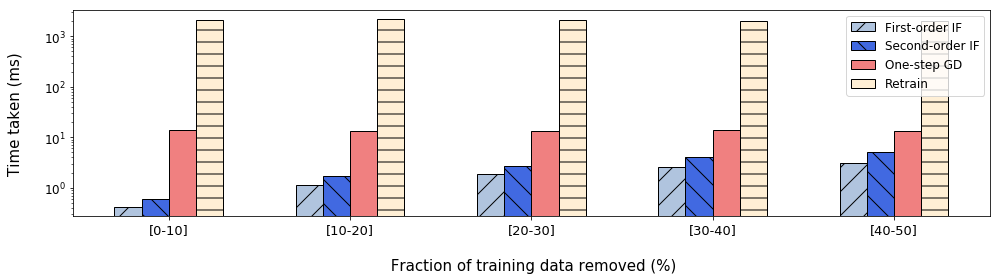

In [29]:
plt.figure(figsize=(14,4))
bin_num = 5
bins_gt = []
bins_gd = []
bins_first = []
bins_second = []
# alpha = 0.7

# for bin_id in range(bin_num):
#     gt_time_in_bin = np.array(gt_ys).copy()
#     first_time_in_bin = np.array(first_ys).copy()
#     second_time_in_bin = np.array(second_ys).copy()
#     gd_time_in_bin = np.array(gd_ys).copy()
#     gt_xs = np.array(gt_xs)

#     in_bin_idx = (gt_xs>=bin_id*10)&(gt_xs<(bin_id+1)*10)
    
#     gt_time_in_bin = gt_time_in_bin[in_bin_idx]
#     first_time_in_bin = first_time_in_bin[in_bin_idx]
#     second_time_in_bin = second_time_in_bin[in_bin_idx]
#     gd_time_in_bin = gd_time_in_bin[in_bin_idx]
    
#     bins_gt.append(gt_time_in_bin)
#     bins_first.append(first_time_in_bin)
#     bins_second.append(second_time_in_bin)
#     bins_gd.append(gd_time_in_bin)

edge_color = np.zeros((bin_num, 4))
edge_color[:, 3] = 1.0 # alpha
edge_width = 1

bar_color_first = np.zeros((bin_num, 4))
bar_color_first[:, 2] = 1.0 # blue
bar_color_first[:, 3] = 0.3 # alpha

bar_color_second = np.zeros((bin_num, 4))
bar_color_second[:, 2] = 1.0 # blue
bar_color_second[:, 3] = 0.7 # alpha

bar_color_gt = np.zeros((bin_num, 4))
bar_color_gt[:, 0] = 61/255
bar_color_gt[:, 1] = 145/255
bar_color_gt[:, 2] = 64/255
bar_color_gt[:, 3] = 1.0 # alpha

bar_color_gd = np.zeros((bin_num, 4))
bar_color_gd[:, :2] = 1.0 # yellow
bar_color_gd[:, 3] = 0.5 # alpha

width = 0.15
index = np.arange(bin_num)
plt.bar(index[:5]-3*width/2, time_first[:5],
        width, label='First-order IF', color='lightsteelblue', hatch='/', linewidth=edge_width, edgecolor=edge_color)
plt.bar(index[:5]-width/2, time_second[:5],
        width, label='Second-order IF', color='royalblue', hatch='\\', linewidth=edge_width, edgecolor=edge_color)
plt.bar(index[:5]+width/2, time_gd[:5],
        width, label='One-step GD', color='lightcoral', linewidth=edge_width, edgecolor=edge_color)
plt.bar(index[:5]+3*width/2, time_gt[:5],
        width, label='Retrain', color='papayawhip', hatch='-', linewidth=edge_width, edgecolor=edge_color)


plt.xticks(range(bin_num), [f'[{bin_id*10}-{(bin_id+1)*10}]' for bin_id in range(bin_num)], fontsize=13, rotation=0)
plt.yticks(fontsize=12)
plt.legend(loc='upper right', fontsize=12)
# , prop={'weight':'bold'})
# plt.grid()
plt.tight_layout()
# plt.title('Comparison on time cost (german)', fontsize=16, fontweight='bold')
plt.xlabel('\n Fraction of training data removed (%)', fontsize=15)
# , fontweight='bold')
plt.ylabel('Time taken (ms)\n', fontsize=15)
plt.yscale("log")
# , fontweight='bold')
plt.tight_layout()
# plt.show()
plt.savefig('time.pdf', dpi=150)

In [45]:
clf_name = 'Logistic'
gt_xs = np.load(f'backup/{clf_name}_gt_xs.npy')
gt_ys = np.load(f'backup/{clf_name}_gt_ys.npy')
gd_xs = np.load(f'backup/{clf_name}_gd_xs.npy')
gd_ys = np.load(f'backup/{clf_name}_gd_ys.npy')
first_xs = np.load(f'backup/{clf_name}_first_xs.npy')
first_ys = np.load(f'backup/{clf_name}_first_ys.npy')
second_xs = np.load(f'backup/{clf_name}_second_xs.npy')
second_ys = np.load(f'backup/{clf_name}_second_ys.npy')

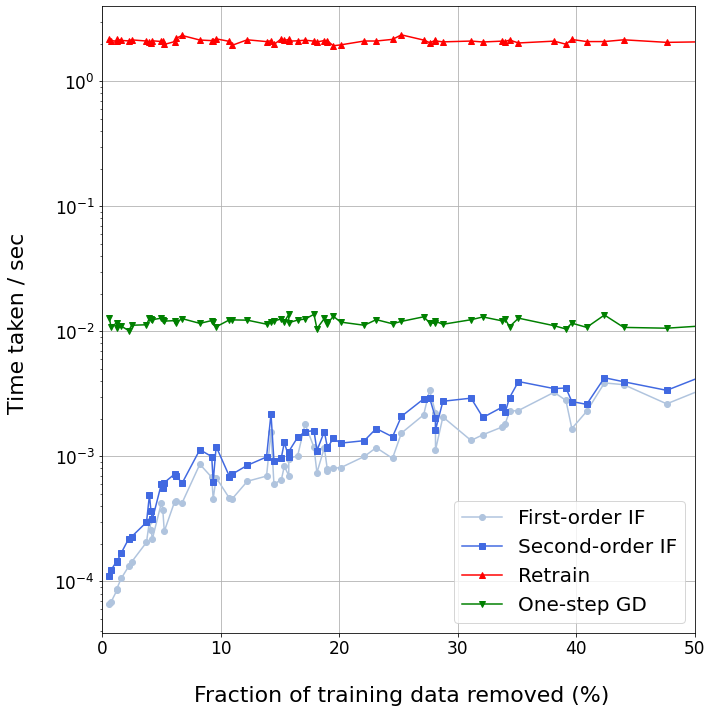

In [46]:
plt.figure(figsize=(10,10))
# fig, ax = plt.subplots()
# ax.tick_params(axis='both', which='major', labelsize=15)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)

plt.plot(first_xs, first_ys, '-', c='lightsteelblue', label='First-order IF', marker="o")
plt.plot(second_xs, second_ys, '-', c='royalblue', label='Second-order IF', marker="s")
plt.plot(gt_xs, gt_ys, '-', c='red', label='Retrain', marker="^")
plt.plot(gd_xs, gd_ys, '-', c='green', label='One-step GD', marker="v")

plt.legend(loc='lower right', fontsize=20)
plt.grid()
plt.xlabel('\n Fraction of training data removed (%)', fontsize=22)
plt.ylabel('Time taken / sec \n', fontsize=22)
plt.yscale("log")
plt.xlim(0, 50)
plt.tight_layout()
# plt.show()
plt.savefig('time-logistic.pdf', dpi=150)